# Get Google and Watson API Results and store on file
-----

## Instantiate the Pipeline

In [1]:
%%time
import importlib
import pipeline
importlib.reload(pipeline)

cnd = pipeline.CND()

print([name for name in cnd.nlp.pipe_names])

['tagger', 'parser', 'ner', 'Named Entity Matcher', 'merge_entities', 'Concept Matcher']
Wall time: 17 s


## Instantiate the Dataset

In [2]:
%%time
import importlib
from IPython.display import clear_output
import cndobjects
importlib.reload(cndobjects)


dirpath = r'C:\\Users\\Steve\\OneDrive - University of Southampton\\CNDPipeline\\dataset'

orators = cndobjects.Dataset(cnd, dirpath)
clear_output(wait=True)

display(orators.summarise())

,,Name,Text Count,Word Count
Ref,,,,
hitler,0,Adolf Hitler,1,"706,100"
bush,1,George Bush,14,"143,936"
king,2,Martin Luther King,5,"122,815"
laden,3,Osama bin Laden,6,"93,646"
Totals,4,,26,"1,066,497"


Wall time: 47.2 s


## Get Google API Results

Get the data from the online API and store on file to save from repeated calls.

Authentication
- https://cloud.google.com/docs/authentication/getting-started

Dashboard
- https://console.cloud.google.com/home/dashboard?project=modern-heading-262419

Documents
- https://cloud.google.com/natural-language/docs/reference/rest

### Initiate API

In [ ]:
%%time
import os
# Imports the Google Cloud client library
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r""
# Instantiates a client
client = language.LanguageServiceClient()

### Get overall document analytics for the Google API

In [ ]:
%%time
import os
from tqdm import tqdm
import pickle

document_results = dict()

#instantiate dict() for each orator()
orators_dict = {}
    
# iterate through each orator() object
for ref, orator in orators.orators_dict.items():
    
    # instantiate orator dict()
    orators_dict[ref] = []
   
    
    # iterate over each Text() of the orator() object
    for text in tqdm(orator.texts, total = len(orator.texts), desc = ref):
    # instantiate document dict()
        document = dict()
        document["title"] = text.title
        document["analytics"] = []

        # Mein Kampf is too large for the Google API, the document sentiment is calculated using an average of sentence sentiments
        if ref == "hitler":
            document["analytics"].append(
                {"sentiment" : 0),
                 "entities" : '',
                 "classifications" : '',
                 "syntax" : ''
                })
            
            orators_dict[ref].append(document)
            break
        
        
        doc_obj = types.Document(
            content=str(text.doc.text),
            type=enums.Document.Type.PLAIN_TEXT)
        encoding_type = enums.EncodingType.UTF8

        document["analytics"] = {"sentiment" : client.analyze_sentiment(document=doc_obj).document_sentiment,
                                 "entities" : client.analyze_entity_sentiment(doc_obj, encoding_type=encoding_type),
                                 "classifications" : client.classify_text(doc_obj),
                                 "syntax" : client.analyze_syntax(doc_obj, encoding_type=encoding_type)
                                }
    
        # append the document object to the orator dict()
        orators_dict[ref].append(document)
        
    # append the orator dict() to the overall dataset
    document_results.update(orators_dict)
    
google_document_results = document_results
# time = 3min 51s

### Save the Google document object to file

the NLP objects for Google can't be stored as a json object, therefore they are serialised using pickle

In [ ]:
%%time

# import os
# import pickle
# filepath = os.getcwd()
# pickle_filename = "google_document_analytics"
# with open(os.path.join(filepath, pickle_filename), 'wb') as file:
#     pickle.dump(google_document_results, file)

### Get sentence level sentiment analytics for Google API

In [ ]:
%%time
import os
import pickle
from tqdm import tqdm
# instantiate dataset dictionary
sentence_sentiment = dict()

#instantiate dict() for each orator()
orators_dict = {}
    
for ref, orator in orators.orators_dict.items():
    
    # instantiate orator dict()
    orators_dict[ref] = list()
    
    # iterator through orator() texts
    for text in orator.texts:
        
        # instantiate document dict()
        document = dict()
        document["title"] = text.title
        document["sentiments"] = list()
        
        # iterator through each sentence of the text and append sentiment score to the sentiments list
        for sentence in tqdm(text.doc.sents, total = len(list(text.doc.sents)), desc = document["title"]):
            
            sent_obj = types.Document(
                content=str(sentence).strip(),
                type=enums.Document.Type.PLAIN_TEXT)
            document["sentiments"].append(client.analyze_sentiment(document=sent_obj).document_sentiment)
            
        # append the document object to the orator dict()
        orators_dict[ref].append(document)
    
    # append the orator dict() to the overall dataset
    sentence_sentiment.update(orators_dict)
    
google_sentence_sentiment = sentence_sentiment
# time = 27min 52s

### Get average sentence sentiment score for Google API

Since Mein Kampf is too large for Google's  open source API, the score is derived from an average of sentence sentiment scores

In [6]:
from statistics import mean

# code for getting average sentence sentiment score
sentence_sentiment_mean = mean([sentiment.score for sentiment in google_sentence_sentiment["hitler"][0]["sentiments"]])

# check for differences between document and sentence level score
for ref, document in google_document_analytics.items():
    for text in range(len(document)):
        if ref == "hitler":
            continue
        doc_score = google_document_analytics[ref][text]["analytics"]["sentiment"].score 
        sent_score = mean([sentiment.score for sentiment in google_sentence_sentiment[ref][text]["sentiments"]])
        n = 2
        difference = round(abs(doc_score - sent_score), n)
        print(f"difference =  {difference}")



difference =  0.06
difference =  0.0
difference =  0.04
difference =  0.07
difference =  0.01
difference =  0.08
difference =  0.02
difference =  0.02
difference =  0.01
difference =  0.06
difference =  0.01
difference =  0.0
difference =  0.03
difference =  0.01
difference =  0.03
difference =  0.02
difference =  0.0
difference =  0.02
difference =  0.03
difference =  0.06
difference =  0.02
difference =  0.01
difference =  0.03
difference =  0.1
difference =  0.0


### Save the Google document object to file

the NLP objects for Google can't be stored as a json object, therefore they are serialised using pickle

In [ ]:
%%time
import os
import pickle

# filepath = os.getcwd()
# pickle_filename = "google_sentence_sentiment"
# with open(os.path.join(filepath, pickle_filename), 'wb') as file:
#     pickle.dump(google_sentence_sentiment, file)

### Get Google data from disk

In [3]:
%%time
import os
import pickle

google_document_analytics_filename = "google_document_analytics"
google_sentence_sentiment_filename = "google_sentence_sentiment"

filepath = os.getcwd()
with open(os.path.join(filepath, google_document_analytics_filename), 'rb') as file:
    google_document_analytics = pickle.load(file)
    
with open(os.path.join(filepath, google_sentence_sentiment_filename), 'rb') as file:
    google_sentence_sentiment = pickle.load(file)
    
print("doc analytics size:", len(google_document_analytics))
print("sentence sentiment size:", len(google_sentence_sentiment))

doc analytics size: 4
sentence sentiment size: 4
Wall time: 359 ms


## Get Watson API Results

Get the data from the online API and store on file to save from repeated calls.

API Documentation
- https://cloud.ibm.com/apidocs/natural-language-understanding

Source Code
- http://watson-developer-cloud.github.io/python-sdk/v1.0.2/_modules/watson_developer_cloud/natural_language_understanding_v1.html

### Initiate Watson API

In [ ]:
%%time
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, ConceptsOptions, EmotionOptions, EntitiesOptions, KeywordsOptions, CategoriesOptions, SentimentOptions

apikey = ''
url = ''

authenticator = IAMAuthenticator(apikey)
service = NaturalLanguageUnderstandingV1(version='2019-07-12', authenticator=authenticator)
service.set_service_url(url)

### Get overall document analytics for the Watson API

Generates output at the for all of Watson's natural langugage processing features.

Output object is in jsonlines format and stored to file.

In [ ]:
%%time
import os
from tqdm import tqdm
import json

# instantiate dataset dictionary
document_results = dict()

#instantiate dict() for each orator()
orators_dict = {}
    
# iterate through each orator() object
for ref, orator in orators.orators_dict.items():
    
    # instantiate orator dict()
    orators_dict[ref] = list()
   
    
    # iterate over each Text() of the orator() object
    for text in tqdm(orator.texts, total = len(orator.texts), desc = ref):
    # instantiate document dict()
        document = dict()
        document["title"] = text.title
        document["ref"] : text.ref
        document["targets"] = targets = list(set([str(ent) for ent in text.doc.ents if ent.label_ in ["GPE", "NORP", "ORG", "PERSON"]])),
        
        document["analytics"] = service.analyze(
                        text=str(text.doc.text),
                        features=Features(
                            concepts=ConceptsOptions(limit=50),
                            emotion=EmotionOptions(targets = targets),
                            entities=EntitiesOptions(emotion=True, sentiment=True),
                            keywords=KeywordsOptions(emotion=True, sentiment=True),
                            categories=CategoriesOptions(),
                            sentiment=SentimentOptions()
                        )).get_result()
        
        # append the document object to the orator dict()
        orators_dict[ref].append(document)
        
    # append the orator dict() to the overall dataset
    document_results.update(orators_dict)
    
watson_document_results = document_results
# time = 1m3s

### Save Watson document object to file

In [ ]:
%%time
# import json
# filepath = os.getcwd()
# json_filename = "watson_document_analytics.json"
# with open(os.path.join(filepath, json_filename), 'w') as file:
#     file.write(json.dumps(watson_document_results))

### Get sentence level sentiment analytics for Watson API

The output object uses the same structure as the orators dataset object.

In [ ]:
%%time
import json
import os
from tqdm import tqdm

# instantiate dataset dictionary
watson_sentiment = dict()

#instantiate dict() for each orator()
orators_dict = {}
    
for ref, orator in orators.orators_dict.items():
    
    # instantiate orator dict()
    orators_dict[ref] = list()
    
    # iterator through orator() texts
    for text in orator.texts:
        
        # instantiate document dict()
        document = dict()
        document["title"] = text.title
        document["sentiments"] = list()
        
        # iterator through each sentence of the text and append sentiment score to the sentiments list
        for sentence in tqdm(text.doc.sents, total = len(list(text.doc.sents))):
            document["sentiments"].append(service.analyze(
                text=str(sentence.text),
                features=Features(sentiment=SentimentOptions()),
                language = "en").get_result())
            
        # aappend the document object to the orator dict()
        orators_dict[ref].append(document)
    
    # append the orator dict() to the overall dataset
    watson_sentiment.update(orators_dict)

### Save Watson sentence sentiment document to file

In [ ]:
%%time
import os
import json

# filepath = os.getcwd()
# json_filename = "watson_sentence_sentiment.json"
# with open(os.path.join(filepath, json_filename), 'w') as file:
#     file.write(json.dumps(watson_sentiment))

### Get Watson data from disk

In [4]:
%%time
import os
import json

watson_document_analytics_filename = "watson_document_analytics.json"
watson_sentence_sentiment_filename = "watson_sentence_sentiment.json"

filepath = os.getcwd()
with open(os.path.join(filepath, watson_document_analytics_filename), 'r') as file:
    watson_document_analytics = json.load(file)
    
with open(os.path.join(filepath, watson_sentence_sentiment_filename), 'r') as file:
    watson_sentence_sentiment = json.load(file)
    
print("doc analytics size:", len(watson_document_analytics))
print("sentence sentiment size:", len(watson_sentence_sentiment))

doc analytics size: 4
sentence sentiment size: 4
Wall time: 85.8 ms


## Extract Relevant Information to Make a Usuable Object for this Task.

Output at the document level is in the following format

`


    google_document_analytics["bush"][4]["analytics"] = #(remember to sort out the metadata clash)
    {"sentiment": {"magnitude": 87.0, "score": -0.10000000149011612},
        "entities": {"entities": [{"name": "al Qaeda", "type": "ORGANIZATION", "metadata": {"key": "mid", "value": "/m/0v74"},
                                   "metadata": {"key": "wikipedia_url", "value": "https://en.wikipedia.org/wiki/Al-Qaeda"},
                                   "salience": 0.009386186487972736,
                                   "mentions": [{"text": {"content": "al Qaeda", "begin_offset": 4680}, "type": "PROPER", "sentiment": {"magnitude": 0.699999988079071, "score": 0.699999988079071}}]}]},
        "classifications": {"categories": {"name": "/Sensitive Subjects",
                                         "confidence": 0.7900000214576721}},
        "syntax": {
        "sentences": {"text": {"content": "The evidence we have gathered all points to a collection of loosely affiliated terrorist organizations known as al Qaeda.", "begin_offset": 3309}},
        "tokens": {"text": {"content": "terrorist", "begin_offset": 3388},
          "part_of_speech": {"tag": "ADJ"},
          "dependency_edge": {"head_token_index": 679, "label": "AMOD"},
          "lemma": "terrorist"}}}

`

`

    google_sentence_sentiment["bush"][4]["sentiments"][32].magnitude = 0.20000000298023224

    google_sentence_sentiment["bush"][4]["sentiments"][32].magnitude.score = -0.20000000298023224

`

Outputs for Watson are the following format:

`
    
    watson_document_analytics["bush"][4]["analytics"] = 
    {"usage": {"text_units": 2, "text_characters": "17321", "features": 5},
     "sentiment": {"document": {"score": -0.331922, "label": "negative"}},
     "language": "en",
     "keywords": [{"text": "United States of America",
                   "sentiment": {"score": -0.535138,
                                 "mixed": "1",
                                 "label": "negative"},
                   "relevance": 0.527585,
                   "emotion": {"sadness": 0.28403,
                               "joy": 0.355131,
                               "fear": 0.328408,
                               "disgust": 0.099274,
                               "anger": 0.113816},
                   "count": 3}],
     "entities": [{"type": "Organization", 
                   "text": "al Qaeda",
                   "sentiment": {"score": -0.738021, 
                                 "mixed": "1", 
                                 "label": "negative"},
                   "relevance": 0.624347,
                   "emotion": {"sadness": 0.174989,
                               "joy": 0.139256,
                               "fear": 0.699752,
                               "disgust": 0.154138,
                               "anger": 0.129947},
                   "disambiguation": {"subtype": ["MembershipOrganization"],
                                      "name": "Al-Qaeda", "dbpedia_resource": "http://dbpedia.org/resource/Al-Qaeda"},
                   "count": 6,
                   "confidence": 1}],
     "concepts": {"text": "Taliban", "relevance": 0.695602, "dbpedia_resource": "http://dbpedia.org/resource/Taliban"},
     "categories": [{"score": 0.954255, "label": "/society/unrest and war"}]
    }

`
                                                            
`
    
    watson_sentence_sentiment["bush"][4]["sentiments"][32] = {'usage': 
                                                             {'text_units': 1, 'text_characters': 134, 'features': 1}, 
                                                              'sentiment': {'document': {'score': 0.920489, 'label': 'positive'}}, 
                                                              'language': 'en'}
                                                        
`
                                                    
The relevant information is as follows:

`
    
    watson_sentiment["bush"][4]["sentiments"][32]["sentiment"]["document"] = 'scores': {'watson': {'score': 0, 'label': 'neutral'}}

`

the output document object for each orator will be a list() of dict() in the following format:

`
    
    document = {"title" : "",
        "sentiment_scores" : {"textblob" : score, "watson" : score, "google" : score},
        "most_pos_sents" : {"textblob" : [(index)], "watson" : [(index)], "google" : [(index)]}, # list of sentences with a score of +1
        "most_neg_sents" : {"textblob" : [(index)], "watson" : [(index)], "google" : [(index)]}, # list of sentence indicies with a score of -1
        "pos_sents" : {"textblob" : [(index, score)], "watson" : [(index, score)], "google" : [(index, score)]}, # sentence indicies with highest score other than +1
        "neg_sents" : {"textblob" : [(index, score)], "watson" : [(index, score)], "google" : [(index, score)]}, # sentence indicies with lowest score other than +1
        "sentences" : []}

`

The output sentence object for each sentence will a list of dict() objects:

`
    
    sent_obj = {"text" : "", "scores" : { 
        "watson" : 0,
        "google" : 0,
        "textblob" : 0
        }}

`

Each sentence object is accessed as follows:

`
    
    <API>_sentiment_analysis["bush"][4]["sentences"][32] = 
    {'text': 'The evidence we have gathered all points to a collection of loosely affiliated terrorist organizations known as al Qaeda.',
    'scores': {'watson': {'score': 0, 'label': 'neutral'}}}

`

## Creating a class object for sentiment analytics

In [7]:
%%time
import os
import pickle
import pandas as pd
import cndobjects
importlib.reload(cndobjects)


class SentimentData(cndobjects.DatasetMaster):
    
    apis = None
    
    def __init__(self, apis = [], filepath = "", filename = ""):
        super().__init__()
        
        SentimentData.apis = apis
        self.filepath = filepath
        self.filename = filename
        
    @property
    def summarise(dataset):
    
        for orator in dataset.orators_dict.values():
            for document in orator:
                line = dict()
                line["ref"] = document["ref"]
                line["datestamp"] = document["datestamp"][0]
                line["title"] = document["title"][0]
                line["word count"] = document["wordcount"]
                line["sentence count"] = len(document["sentences"])
                
                for api in SentimentData.apis:
                    line[api] = document["sentiment_scores"][api]

                yield line
                
    @property
    def df(self):
        return pd.DataFrame(self.summarise)
    

    def toDisk(self):
        
        with open(os.path.join(self.filepath, self.filename), 'wb') as file:
            print("writing: ", self.filename, "to:")
            print(self.filepath)
            pickle.dump(self.orators_dict, file)
            
    def fromDisk(self):
        
        with open(os.path.join(filepath, pickle_filename), 'rb') as file:
            print("loading:", self.filename, "from:")
            print(self.filepath)
            sentiment_analytics.orators_dict = pickle.load(file)

Wall time: 2 ms


In [ ]:
%%time

minmax = dict()

for ref, orator in sentiment_analytics.items():
    
    documents = list()
    
    for text in orator:
            
        document = dict()

        # list of sentences with a score of +1
        # list of sentence indicies with a score of -1
#             sentence["most_pos_sents"] = {api : [] for api in sentiment_analytics.apis}
#             sentence["most_neg_sents"] = {api : [] for api in sentiment_analytics.apis}
        document["most_pos_sents"] = list()
        document["most_neg_sents"] = list()

        # sentence indicies with highest score other than +1
        # sentence indicies with lowest score other than -1
        document["pos_sents"] = {api : {"text" : "", "score" : ""} for api in sentiment_analytics.apis}
        document["neg_sents"] = {api : {"text" : "", "score" : ""} for api in sentiment_analytics.apis}
        
        print(text["title"])
        for sent in text["sentences"]:

            maximum = {api : 0 for api in sentiment_analytics.apis}
            minimum = {api : 0 for api in sentiment_analytics.apis}

            sent_scores = dict()
            for entry in sent:
                sent_scores["text"] = sent["text"]
                sent_scores.update(sent["scores"])

            for api in sentiment_analytics.apis:

                if sent["scores"][api] == 1:
                    document["most_pos_sents"].append(sent_scores)
#                     print(text["title"])
#                     print(f'list of most pos sents {document["most_pos_sents"]}')

                if sent["scores"][api] == -1:
                    document["most_neg_sents"].append(sent_scores)
#                     print(text["title"])
#                     print(f'list of most neg sents {document["most_neg_sents"]}')

                if sent["scores"][api] < 1 and sent["scores"][api] > maximum[api]:
                    maximum[api] = sent["scores"][api]
                    print(api, '=>', maximum[api], '=>', sent["text"])
                    document["pos_sents"][api]["text"] = sent["text"]
                    document["pos_sents"][api]["score"] = sent["scores"][api]
#                     print(document["pos_sents"])

                if sent["scores"][api] > -1 and sent["scores"][api] < minimum[api]:
                    minimum[api] = sent["scores"][api]
                    document["neg_sents"][api]["text"] = sent["text"]
                    document["neg_sents"][api]["score"] = sent["scores"][api]
#                     print(document["neg_sents"])
        print('----------------------------------')
        documents.append(document)

    minmax[ref] = documents


In [58]:
n = 4
display(pd.DataFrame(minmax["king"][n]["neg_sents"]).T)
display(pd.DataFrame(minmax["king"][n]["pos_sents"]).T)

,text,score
textblob,""" We shall overcome because James Russell Lowell is right, ""Truth forever on the scaffold, Wrong forever on the throne —",-0.107143
watson,""" We shall overcome because James Russell Lowell is right, ""Truth forever on the scaffold, Wrong forever on the throne —",-0.358856
google,"We shall overcome because Carlyle is right, ""No lie can live forever.",-0.5


,text,score
textblob,"In the words of the Scripture, to speak symbolically, that will be the day when the morning stars will sing together and the sons of God will shout for joy.",0.8
watson,"In the words of the Scripture, to speak symbolically, that will be the day when the morning stars will sing together and the sons of God will shout for joy.",0.89731
google,"In the words of the Scripture, to speak symbolically, that will be the day when the morning stars will sing together and the sons of God will shout for joy.",0.6


### Create the Sentiment Analytics Object

In [69]:
%%time
import importlib

from statistics import mean
from tqdm import tqdm
from textblob import TextBlob
import pandas as pd

import cndobjects
importlib.reload(cndobjects)

apis = ["textblob", "watson", "google"]
sentiment_analytics = SentimentData(apis = apis,
                                   filepath = os.getcwd(),
                                   filename = "sentiment_analytics")

for ref, orator in orators.orators_dict.items():

    documents = list()

    for text in range(len(orator.texts)):
        
        document = dict()

        document["ref"] = ref
        document["title"] = orators[ref][text].title, ## !!! why does this instantiate as a tuple
        document["datestamp"] = orators[ref][text].datestamp,
        document["wordcount"] = len(orators[ref][text].doc.text)

        document["sentiment_scores"] = dict()
        document["sentences"] = list()
    
        document["sentiment_scores"]["textblob"] = TextBlob(str(orators[ref][text].doc.text)).sentiment[0]

        # add watson scores
        document["sentiment_scores"]["watson"] = watson_document_analytics[ref][text]["analytics"]["sentiment"]["document"]["score"]

        # add google scores (mein kampf doc score is the mean of sentence sentiment scores)
        if orators[ref][text].title == "Mein Kampf":
            document["sentiment_scores"]["google"] = mean([sentiment.score for sentiment in google_sentence_sentiment["hitler"][0]["sentiments"]])
        else:
            document["sentiment_scores"]["google"] = google_document_analytics[ref][text]["analytics"]["sentiment"].score
            
        sentence_text = list(orators[ref][text].doc.sents)
        
        for sentence in tqdm(range(len(sentence_text)), total = len(sentence_text), desc = orators[ref][text].title):
            
            # initiate sent object
            sent = dict()
            
            # get the sentence text
            sent["text"] = str(sentence_text[sentence]).strip()
            
            # initate scores object
            sent["scores"] = dict()
            
            api = "textblob"
            sent["scores"][api] = TextBlob(sent["text"]).sentiment[0]
                
            api = "watson"
            sent["scores"][api] = watson_sentence_sentiment[ref][text]["sentiments"][sentence]["sentiment"]["document"]["score"]
                
            api = "google"
            sent["scores"][api] = google_sentence_sentiment[ref][text]["sentiments"][sentence].score
        
            document["sentences"].append({"text" : sent["text"], "scores" : sent["scores"]})
            
        documents.append(document)
    
    sentiment_analytics[ref] = documents

911 Address to the Nation: 100%|██████████| 37/37 [00:00<00:00, 2061.00it/s]
Remarks at the National Day of Prayer & Remembrance Service: 100%|██████████| 57/57 [00:00<00:00, 1786.01it/s]
Address at Islamic Center of Washington, D.C.: 100%|██████████| 39/39 [00:00<00:00, 1862.10it/s]
Address to Joint Session of Congress Following 911 Attacks: 100%|██████████| 186/186 [00:00<00:00, 2168.58it/s]
Operation Enduring Freedom in Afghanistan Address to the Nation: 100%|██████████| 57/57 [00:00<00:00, 1970.67it/s]
Address on Signing the USA Patriot Act of 2001: 100%|██████████| 64/64 [00:00<00:00, 2070.14it/s]
First Address to the United Nations General Assembly: 100%|██████████| 177/177 [00:00<00:00, 2816.95it/s]
The World Will Always Remember 911: 100%|██████████| 34/34 [00:00<00:00, 3100.27it/s]
First (Official) Presidential State of the Union Address: 100%|██████████| 221/221 [00:00<00:00, 2954.80it/s]
The Other America: 100%|██████████| 291/291 [00:00<00:00, 2701.67it/s]
Declaration of Ji

Wall time: 5.58 s


### Save the sentence sentiments object to file

In [70]:
%%time
sentiment_analytics.toDisk()

writing:  sentiment_analytics to:
C:\Users\Steve\OneDrive - University of Southampton\CNDPipeline\Quantitative Analysis
Wall time: 15.9 ms


In [27]:
sentiment_analytics.df    

,ref,datestamp,title,word count,sentence count,textblob,watson,google
0,hitler,2020-06-30,Mein Kampf,706100,4527,0.096408,0.373203,-0.225447
1,bush,2001-09-11,911 Address to the Nation,3482,37,0.093816,0.469524,0.000000
2,bush,2001-09-14,Remarks at the National Day of Prayer & Remembrance Service,5116,57,0.153784,0.298916,0.000000
3,bush,2001-09-15,First Radio Address following 911,2667,30,0.196519,0.351540,0.000000
4,bush,2001-09-17,"Address at Islamic Center of Washington, D.C.",2695,39,-0.076026,0.333191,0.000000
5,bush,2001-09-20,Address to Joint Session of Congress Following 911 Attacks,17321,186,0.132154,-0.331922,-0.100000
6,bush,2001-10-07,Operation Enduring Freedom in Afghanistan Address to the Nation,5693,57,0.167453,0.386644,0.000000
7,bush,2001-10-11,911 Pentagon Remembrance Address,6673,93,0.061266,-0.331954,-0.100000
8,bush,2001-10-11,Prime Time News Conference on War on Terror,4262,37,0.147233,0.333918,0.000000
9,bush,2001-10-11,Prime Time News Conference Q&A,32002,410,0.118774,0.297858,-0.100000


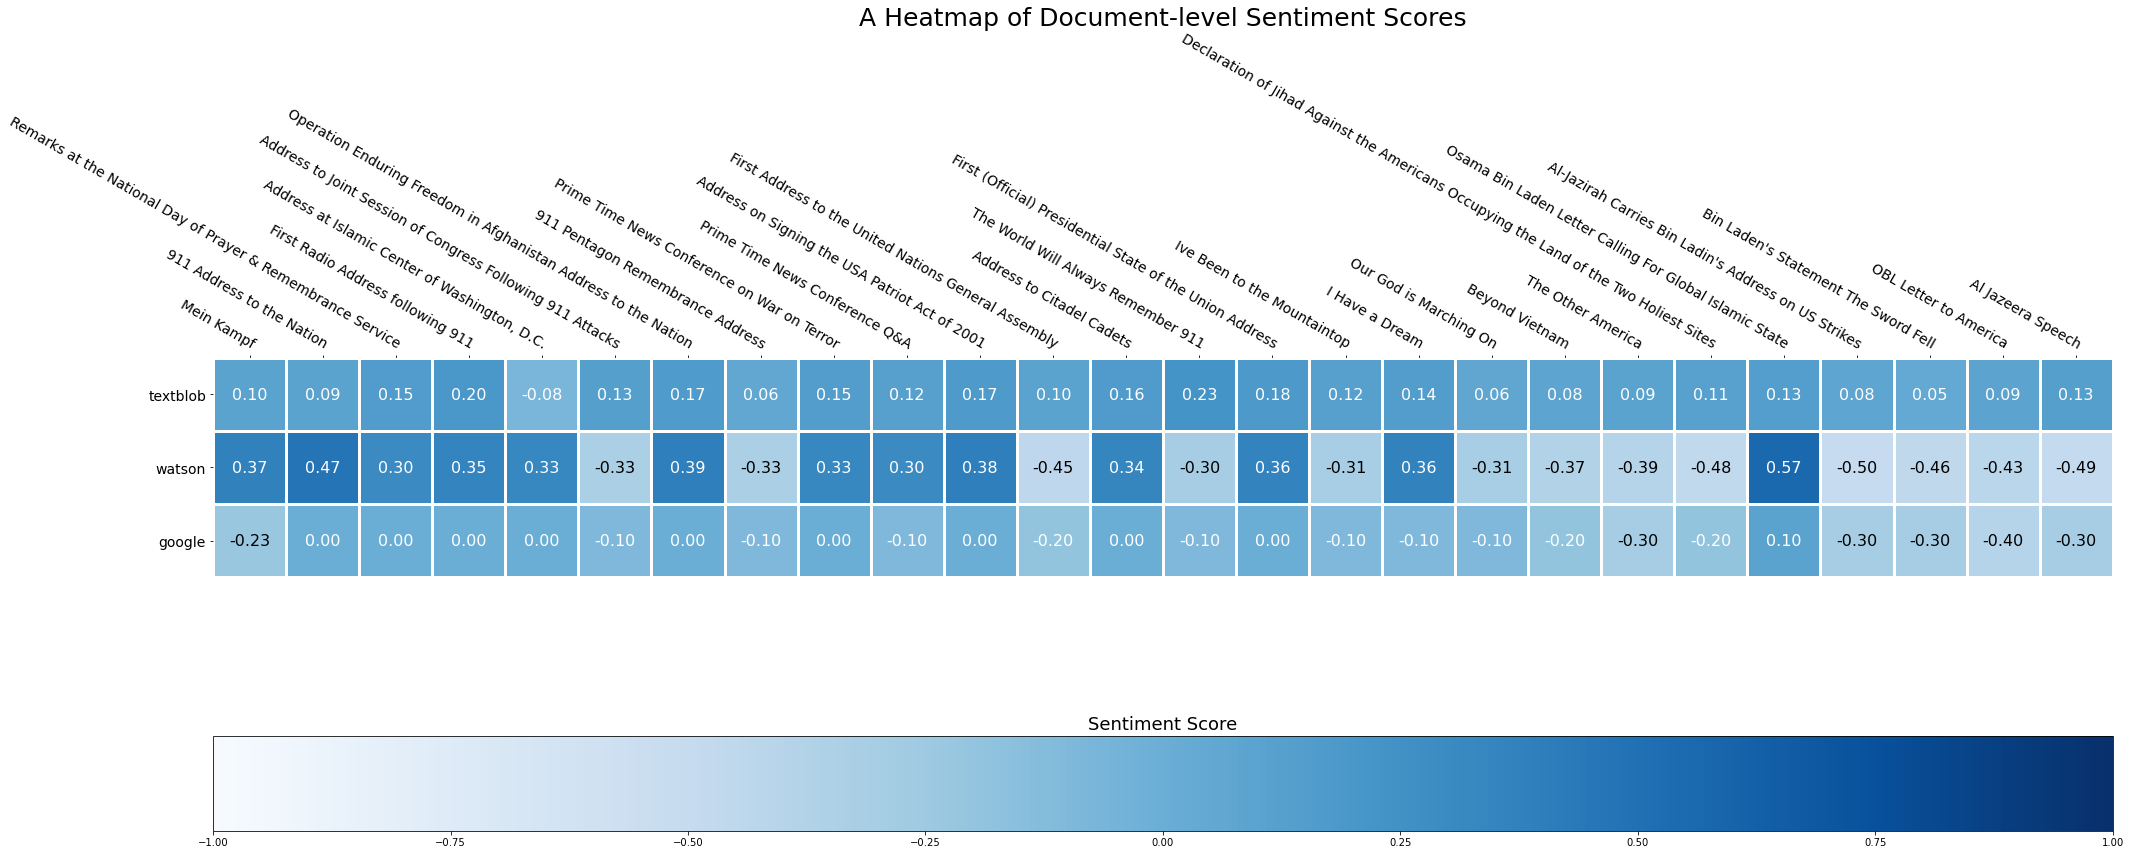

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import cndplots
importlib.reload(cndplots)

fig, ax = plt.subplots(figsize = (30, 15))

api_list = ["textblob", "watson", "google"]

df = pd.DataFrame(summarise(sentiment_analytics)) 

scores = np.array([df[api] for api in api_list])


im, cbar = cndplots.heatmap(scores,
                    api_list,
                    df["title"], 
                    ax=ax,
                    figtitle = "A Heatmap of Document-level Sentiment Scores",
                    cmap="Blues", cbarlabel="Sentiment Score")

texts = cndplots.annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

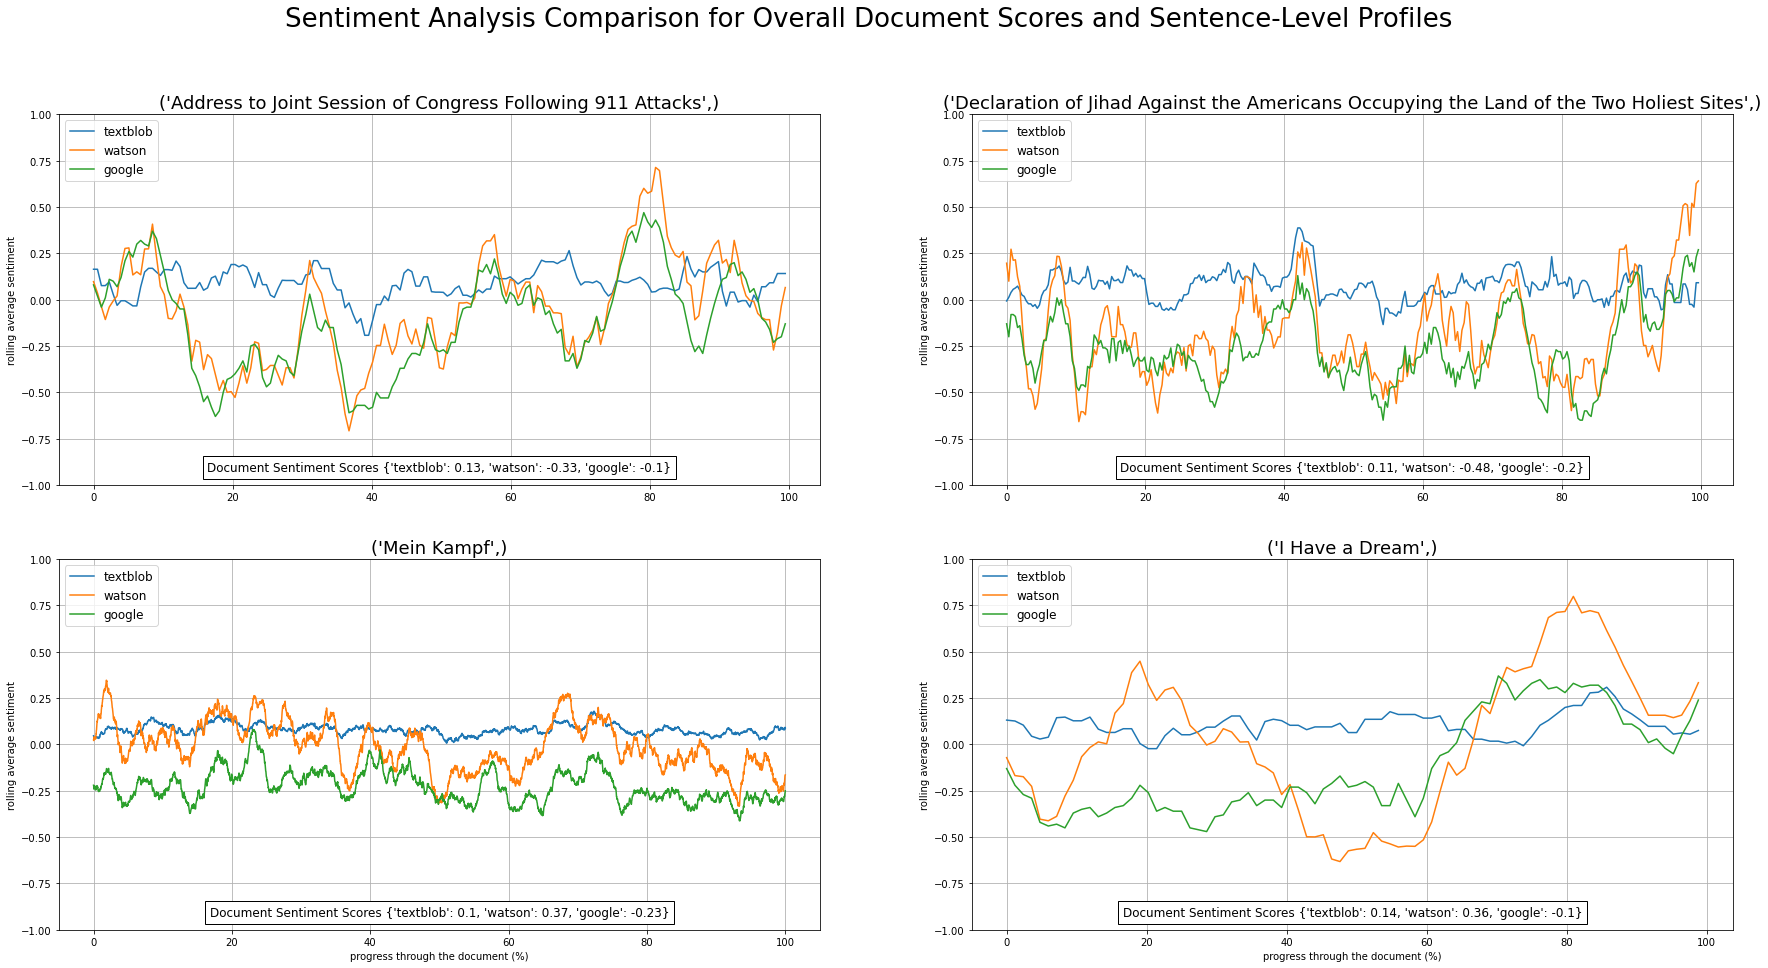

In [30]:
# define smooting algorithm
def smoothing(sentiment_list, window_size):
    window_size = window_size
    numbers_series = pd.Series(sentiment_list)
    windows = numbers_series.rolling(window_size)
    moving_averages = windows.mean()

    moving_averages_list = moving_averages.tolist()
    
    return moving_averages_list[window_size - 1:]

# create list of x-axis references based on smoothed y-axis data
def x_axis_smooth(sentiment_list):
    total_len = len(sentiment_list)
    return [(i / total_len)*100 for i in range(total_len)]

def sentiment_plot(plot_list, dataset, smooth = True, \
                    figtitle = "",
                    xlabel = "",
                    ylabel = "",
                    text_box = ""):
    
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 18

    matplotlib.rc('legend', fontsize=MEDIUM_SIZE)
    matplotlib.rc('axes', titlesize=BIGGER_SIZE)

    #instantiate subplots
    fig, axes = plt.subplots(nrows = ceil(len(plot_list)/2), ncols = floor(len(plot_list)/2), figsize = (30, 15))

    # iterate through each subplot to plot data
    for n, plot in enumerate(axes.flatten()):

        # get document and api references
        orator = plot_list[n][0]
        doc_index = plot_list[n][1]
        # api reference
        line_legend = dataset.apis

        # set the y-axis limits from -1 to +1
        plot.set_ylim([-1,1])

        # turn on grid
        plot.grid()

        # get document title
        title = dataset[orator][doc_index]["title"]

        # add text box to plot
        doc_scores = {k : round(v, 2) for k, v in dataset[orator][doc_index]["sentiment_scores"].items()}
        plot.add_artist(AnchoredText(f'Document Sentiment Scores {doc_scores}', loc=8, prop={'size': MEDIUM_SIZE}))

        # iterate through lines reference and plot the results
        for line in line_legend:
            y_axis = [score["scores"][line] for score in dataset[orator][doc_index]["sentences"]]
            if smooth:
                y_axis = smoothing(y_axis, plot_list[n][2])
                plot.plot(x_axis_smooth(y_axis), y_axis, label = line)
            else:
                x_axis = [i for i in range(len(dataset[orator][doc_index]["sentences"]))]
                plot.plot(x_axis, y_axis, label = line)

        # turn on legend and set document metadata
        plot.legend(loc = "upper left")
        if n >= len(plot_list) - floor(len(plot_list)/2):
            plot.set_xlabel(xlabel)
        plot.set(ylabel=ylabel, title=title)
        fig.suptitle(figtitle, fontsize = 26)
    
    return fig

orators_list = [("bush", 4, 10), ("laden", 0, 10), ("hitler", 0, 100), ("king", 1, 10)]

fig = cndplots.sentiment_plot(orators_list, sentiment_analytics, smooth = True, \
                    figtitle = 'Sentiment Analysis Comparison for Overall Document Scores and Sentence-Level Profiles',
                    xlabel = 'progress through the document (%)',
                    ylabel = 'rolling average sentiment')
fig.savefig(fname = "sentiment_plots")